In [1]:
#Loading libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_file, output_notebook, show, curdoc
from bokeh.plotting import figure
from bokeh.layouts import Column, widgetbox, Row
from bokeh.palettes import Viridis256, Spectral6, Blues8, RdYlBu11 as palette
from bokeh.models import Slider, Select, TextInput, DataTable, TableColumn, ColumnDataSource, CDSView, CustomJS, LinearColorMapper, ColumnDataSource, GeoJSONDataSource, CategoricalColorMapper, LogColorMapper, HoverTool
from bokeh.client import push_session
import subprocess
import time

In [2]:
#Setting the filepath and loading in a shapefile
file = "./files/countries.shp"
map_df = gpd.read_file(file)

#Loading the datasets & doing some data processing like column re-naming
df = pd.read_csv('./files/index.csv')
lang = pd.read_csv('./files/languages.csv', encoding = 'cp1252')
lang.columns = ['lang_id', 'code', 'language_name', 'perc_of_people_spoken', 'official']
countries = pd.read_csv('./files/countries.csv', encoding = 'cp1252')
countries.columns = ['country_name', 'iso_2', 'code']
df.columns = ['rank', 'code', 'country', 'ethnic_index', 'cultural_index']
regions = pd.read_csv('./files/regions.csv')

In [3]:
#Merging shp and file with the cultural index file to build a map based on the data
#As every language is in a separate row, aggregating the languages, % of people spoken and the language status
merged_index = map_df.set_index('ADM0_A3').join(df.set_index('code')).reset_index()
lang['aggregated'] = lang.iloc[:,2]+' (' + lang.iloc[:,3].astype(str) + '; ' +lang.iloc[:,4] + ')'
pvt = lang[['lang_id','code','aggregated']].pivot_table(index = 'code',columns = 'aggregated')
final_aggreg = pd.DataFrame(pvt.apply(lambda x: x.dropna().reset_index()['aggregated'].tolist(), axis = 1)).reset_index()
final_aggreg.columns = ['code', 'lang']
merged_lang = merged_index.set_index('ADM0_A3').join(final_aggreg.set_index('code')).reset_index()
#merged_lang.fillna(0, inplace=True)

In [4]:
# Merging the geo file with the csv to get the desired columns
geo_source = GeoJSONDataSource(geojson = merged_lang.to_json())

tooltips = """
    <div style="width:150px";>
        <div>
            <span style="font-size: 10px; font-weight: bold;">Country:</span>
            <span style="font-size: 10px">@ADMIN</span>
        </div>
        <div>
            <span style="font-size: 10px; font-weight: bold;">Cultural Diversity Index:</span>
            <span style="font-size: 10px">@cultural_index</span>
        </div>        
        <div>
            <span style="font-size: 10px; font-weight: bold;">Lang (% pop; official):</span>
            <span style="font-size: 10px">@lang</span>
        </div>           
    </div>
"""
color_mapper = LinearColorMapper(palette = Blues8)

#Creating a placeholder
p = figure(title ='List of countries ranked by cultural diversity level', tooltips = tooltips, height = 400, width = 600) 

#Drawing the map
p.patches('xs', 'ys', fill_color = {'field': 'cultural_index', 'transform': color_mapper},
         line_color='black', line_width = 0.5, source = geo_source)
p.axis.visible = False

In [5]:
#Creating an interactive table
merged_countries = lang.set_index('code').join(countries.set_index('code')).drop(['lang_id', 'aggregated', 'iso_2'], axis=1).reset_index()
merged_c_cleaned = merged_countries[~merged_countries['language_name'].isin(['unspecified', 'Other', 'unknown', 'none', 
                                                                            'multilingual', 'many', 'foreign', 'and',
                                                                            'foreign', 'government'])].fillna('NaN')
lst_lang = merged_c_cleaned.language_name.sort_values().unique().tolist()
lst_countr = merged_c_cleaned.country_name.sort_values().unique().tolist()
select_lang = Select(title = "Select language", options = lst_lang)
select_count = Select(title = "Select country", options = lst_countr)

source = ColumnDataSource(merged_c_cleaned)
columns = [
        TableColumn(field = "language_name", title = "Language name"),    
        TableColumn(field = "code", title = "Code"),
        TableColumn(field = "country_name", title = "Country name"),    
        TableColumn(field = "official", title = "Official language"),
        TableColumn(field = "perc_of_people_spoken", title = "% of people spoken")]
data_table = DataTable(source = source, columns = columns)

filteredSource = ColumnDataSource(data = dict(code = [], 
                                              country_name = [], 
                                              language_name = [], 
                                              official = [],
                                              perc_of_people_spoken = []))

callback = CustomJS(args = dict(source = source, filteredSource = filteredSource), code = """
var data = source.data;
var f = cb_obj.value;
var d2 = filteredSource.data;
d2['language_name'] = []
d2['code'] = []
d2['country_name'] = []
d2['official'] = []
d2['perc_of_people_spoken'] = []

for(i = 0; i < data['language_name'].length;i++){

if(data['language_name'][i] == f){

    d2['code'].push(data['code'][i])
    d2['country_name'].push(data['country_name'][i])
    d2['language_name'].push(data['language_name'][i])
    d2['official'].push(data['official'][i])    
    d2['perc_of_people_spoken'].push(data['perc_of_people_spoken'][i])        
}
}

for(i = 0; i < data['country_name'].length;i++){

if(data['country_name'][i] == f){

    d2['code'].push(data['code'][i])
    d2['country_name'].push(data['country_name'][i])
    d2['language_name'].push(data['language_name'][i])
    d2['official'].push(data['official'][i])    
    d2['perc_of_people_spoken'].push(data['perc_of_people_spoken'][i])        
}
}

filteredSource.change.emit()

""")
controls = [select_lang, select_count]
for control in controls:
    control.js_on_change('value', callback)

data_table = DataTable(source = filteredSource, columns = columns)
layout = Row(p, Row(widgetbox(select_lang, select_count, data_table)))
output_file('index.html')
show(layout)

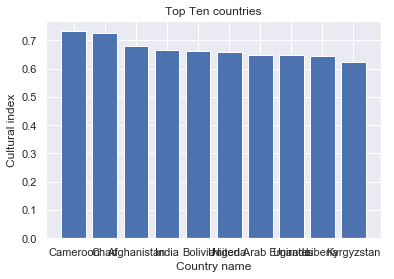

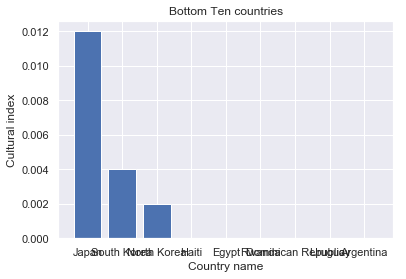

In [6]:
#Exploring the dataset
top_five = df.sort_values(by='cultural_index', ascending=False).head(10); top_five
bottom_five = df.sort_values(by='cultural_index', ascending=False).tail(10); bottom_five

# Ploting box graphs of top and bottom countries
sns.set()
_ = plt.bar(top_five['country'], top_five['cultural_index'])
_ = plt.ylabel('Cultural index')
_ = plt.xlabel('Country name')
_ = plt.title('Top Ten countries')
plt.show()
_ = plt.bar(bottom_five['country'], bottom_five['cultural_index'])
_ = plt.ylabel('Cultural index')
_ = plt.xlabel('Country name')
_ = plt.title('Bottom Ten countries')
plt.show()

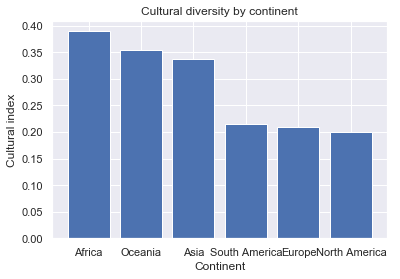

In [7]:
#Analysis by continent
merged_c_r = df.set_index('code').join(regions.set_index('code')).reset_index()
merged_cont_mean = merged_c_r.drop(['rank', 'ethnic_index'], axis = 1).groupby('continent').mean().sort_values(by='cultural_index', ascending = False).reset_index()
_ = plt.bar(merged_cont_mean['continent'], merged_cont_mean['cultural_index'])
_ = plt.ylabel('Cultural index')
_ = plt.xlabel('Continent')
_ = plt.title('Cultural diversity by continent')
plt.show()

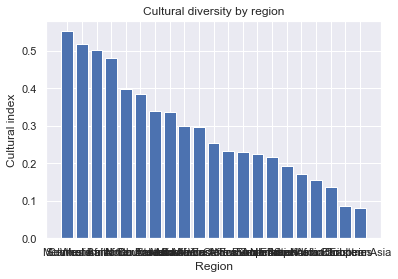

In [8]:
#Analysis by region
merged_r_mean = merged_c_r.drop(['rank', 'ethnic_index'], axis = 1).groupby('region').mean().sort_values(by='cultural_index', ascending = False).reset_index()
_ = plt.bar(merged_r_mean['region'], merged_r_mean['cultural_index'])
_ = plt.ylabel('Cultural index')
_ = plt.xlabel('Region')
_ = plt.title('Cultural diversity by region')
plt.show()